# Participant Prediction

In [1]:
%precision 3
%matplotlib inline

In [2]:
# Year to predict for
PREDICTION_YEAR = 2017

# Year to train prediction for
TRAINING_PREDICTION_YEAR = PREDICTION_YEAR - 1

# Percent of dataset to use for training
TRAINING_DATA_PERCENT = 0.70

# Available year range
MIN_YEAR = 2003
MAX_YEAR = 2016

## Preprocessing

In [3]:
import data
import pandas as pd

In [4]:
def get_recurring_runners_from(df, curr_year, target_year):
    return df.loc[(df.year == target_year) & (df.years_since_run == target_year - curr_year)]


def set_participated_in_year(df, curr_year, target_year):
    next_df = get_recurring_runners_from(df, curr_year, target_year)
    recurring_ids = next_df.id.unique()
    df.loc[(df.year == curr_year) & (df.id.isin(recurring_ids)), "participated_in_year"] = True
    
    
def set_all_participated_in_year(df, target_year):
    for year in range(MIN_YEAR, target_year):
        set_participated_in_year(df, year, target_year)

In [5]:
raw_df = data.get_data()
df = pd.DataFrame()

df["id"] = raw_df["id"]
df["age"] = raw_df["age"].apply(lambda x: 5 * (x // 5))
df["male"] = raw_df["male"]
df["year"] = raw_df["year"]
df["run_count"] = raw_df["run_count"]
df["years_since_run"] = raw_df["years_since_run"].apply(lambda x: max(0, x))
df["ran_last_year"] = raw_df["years_since_run"].apply(lambda x: x == 1)
df["years_to_prediction"] = raw_df["year"].apply(lambda x: TRAINING_PREDICTION_YEAR - x)
df["time_in_seconds"] = raw_df["time_in_seconds"]
df["ignore"] = raw_df["ignore"]
df["participated_in_year"] = False

all_df = df.copy()    

df = df.loc[df.ignore == False]
df = df.sample(frac=1)

In [6]:
df

,id,age,male,year,run_count,years_since_run,ran_last_year,years_to_prediction,time_in_seconds,ignore,participated_in_year
30746,22717,30,1,2012,0,0,False,4,9513.0,False,False
28817,20948,35,1,2012,0,0,False,4,13749.0,False,False
9843,5825,35,1,2004,0,0,False,12,15863.0,False,False
20767,14307,30,0,2009,0,0,False,7,13034.0,False,False
749,461,40,1,2014,1,3,False,2,16707.0,False,False
3338,2043,35,1,2013,0,0,False,3,12334.0,False,False
17694,11884,35,1,2008,0,0,False,8,14303.0,False,False
35944,27612,35,1,2014,0,0,False,2,15775.0,False,False
1701,1038,35,1,2012,1,1,True,4,20510.0,False,False
9288,5473,35,1,2004,0,0,False,12,19263.0,False,False


## Splitting data

In [7]:
import numpy as np

In [8]:
def get_data_for_year(year):
    dataset = df.copy()
    set_all_participated_in_year(dataset, year)
    dataset["years_to_prediction"] = dataset["year"].apply(lambda x: year - x)
    return dataset[dataset.year < year]


def split_data(df):
    training_mask = np.random.rand(len(df)) < TRAINING_DATA_PERCENT
    training = df[training_mask]
    testing = df[~training_mask]
    return training, testing

In [9]:
training, testing = split_data(get_data_for_year(MIN_YEAR))
for year in range(MIN_YEAR + 1, TRAINING_PREDICTION_YEAR):
    curr_training, curr_testing = split_data(get_data_for_year(year))
    training = training.append(curr_training, ignore_index=True)
    testing = testing.append(curr_testing, ignore_index=True)

In [10]:
def get_nb_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "years_to_prediction"]]


def get_reg_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "time_in_seconds"]]


def get_outputs(df):
    return df["participated_in_year"]


def count(df):
    return df.count().id

In [11]:
training_nb_inputs = get_nb_inputs(training)
training_reg_inputs = get_reg_inputs(training)
training_outputs = get_outputs(training)

testing_nb_inputs = get_nb_inputs(testing)
testing_reg_inputs = get_reg_inputs(testing)
testing_outputs = get_outputs(testing)

In [12]:
training_positives = count(training[training.participated_in_year])
training_total = count(training)

testing_positives = count(testing[testing.participated_in_year])
testing_total = count(testing)

In [13]:
training_positives, training_total, training_positives / training_total

(5063, 126884, 0.040)

In [14]:
testing_positives, testing_total, testing_positives / testing_total

(2079, 54550, 0.038)

## Training

#### Bernoulli Naive Bayes

In [15]:
from sklearn.naive_bayes import BernoulliNB

In [16]:
bnb = BernoulliNB()
bnb = bnb.fit(training_nb_inputs, training_outputs)

In [17]:
bnb_predictions = bnb.predict(testing_nb_inputs)

#### Gaussian Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

In [19]:
gnb = GaussianNB()
gnb = gnb.fit(training_nb_inputs, training_outputs)

In [20]:
gnb_predictions = gnb.predict(testing_nb_inputs)

#### Multinomial Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
mnb = MultinomialNB()
mnb = mnb.fit(training_nb_inputs, training_outputs)

In [23]:
mnb_predictions = mnb.predict(testing_nb_inputs)

#### Custom Multinomial Naive Bayes

In [24]:
from naive_bayes import MultinomialNaiveBayes

In [25]:
custom_mnb = MultinomialNaiveBayes()
custom_mnb.fit(training_nb_inputs.as_matrix(), training_outputs.as_matrix())

In [26]:
custom_mnb_predictions = custom_mnb.predict(testing_nb_inputs.as_matrix())

#### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
reg = LogisticRegression()
reg = reg.fit(training_reg_inputs, training_outputs)

In [29]:
reg_predictions = reg.predict(testing_reg_inputs)

## Testing

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [31]:
_ = np.seterr(divide="ignore", invalid="ignore")

In [32]:
def get_confusion_matrix_as_df(c_matrix):
    confusion_df = pd.DataFrame(c_matrix,
                                index=["N", "Y"],
                                columns=["N", "Y"])

    percent_df = confusion_df.applymap(lambda x: x / c_matrix.sum())

    return confusion_df, percent_df


def plot_confusion_matrix(confusion, percent):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    sns.heatmap(confusion, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(percent, annot=True, ax=axs[1])

    
def score(c_matrix):
    TN = c_matrix[0, 0]
    FN = c_matrix[1, 0]
    TP = c_matrix[1, 1]
    FP = c_matrix[0, 1]

    accuracy = (TN + TP) / c_matrix.sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (FP + TN)
    false_positive_rate = FP / (FP + TN)
    f1_measure = 2 * (precision * recall) / (precision + recall)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "false_positive_rate": false_positive_rate,
        "f1_measure": f1_measure
    }


def measure(predictions, truth):
    c_matrix = confusion_matrix(truth, predictions)
    
    # Fix for when only a single class appears.
    if c_matrix.shape == (1, 1):
        fixed_c_matrix = np.zeros((2, 2), dtype=np.int32)
        fixed_c_matrix[0, 0] = c_matrix[0, 0]
        c_matrix = fixed_c_matrix

    plot_confusion_matrix(*get_confusion_matrix_as_df(c_matrix))
    return score(c_matrix)

#### Expected Distribution

{'accuracy': 1.000,
 'f1_measure': 1.000,
 'false_positive_rate': 0.000,
 'precision': 1.000,
 'recall': 1.000,
 'specificity': 1.000}

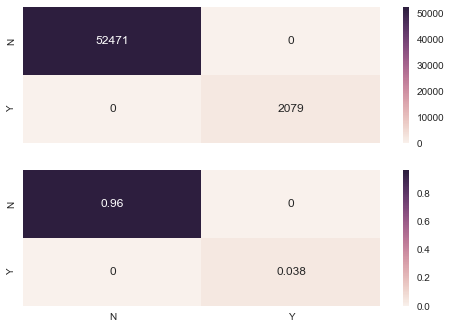

In [33]:
measure(testing_outputs, testing_outputs)

#### Bernouilli Naive Bayes

{'accuracy': 0.962,
 'f1_measure': nan,
 'false_positive_rate': 0.000,
 'precision': nan,
 'recall': 0.000,
 'specificity': 1.000}

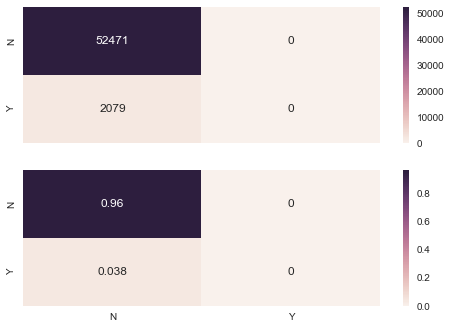

In [34]:
measure(bnb_predictions, testing_outputs)

#### Gaussian Naive Bayes

{'accuracy': 0.927,
 'f1_measure': 0.146,
 'false_positive_rate': 0.043,
 'precision': 0.132,
 'recall': 0.165,
 'specificity': 0.957}

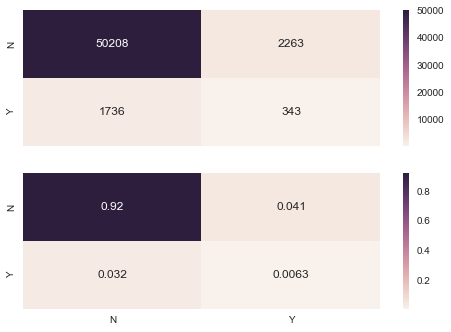

In [35]:
measure(gnb_predictions, testing_outputs)

#### Multinomial Naive Bayes

{'accuracy': 0.931,
 'f1_measure': 0.207,
 'false_positive_rate': 0.042,
 'precision': 0.184,
 'recall': 0.238,
 'specificity': 0.958}

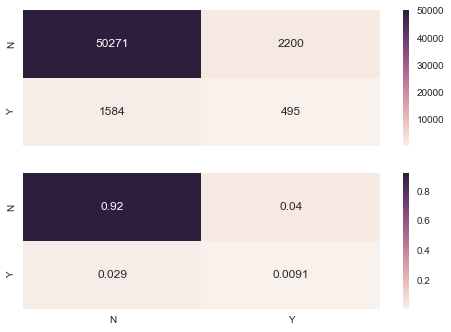

In [36]:
measure(mnb_predictions, testing_outputs)

#### Custom Multinomial Naive Bayes

{'accuracy': 0.958,
 'f1_measure': 0.220,
 'false_positive_rate': 0.010,
 'precision': 0.386,
 'recall': 0.154,
 'specificity': 0.990}

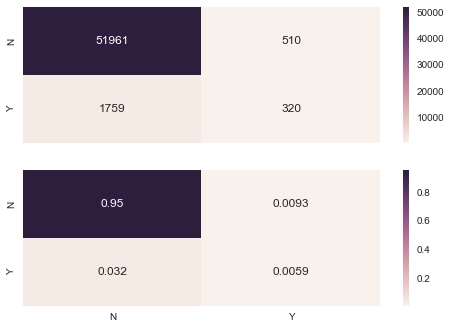

In [37]:
measure(custom_mnb_predictions, testing_outputs)

#### Logistic Regression

{'accuracy': 0.962,
 'f1_measure': nan,
 'false_positive_rate': 0.000,
 'precision': nan,
 'recall': 0.000,
 'specificity': 1.000}

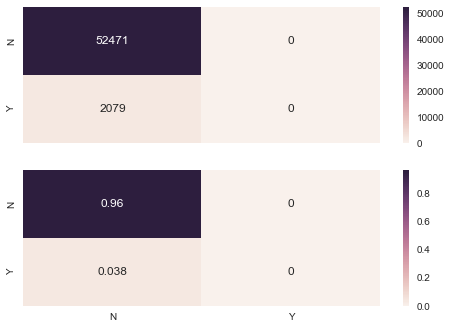

In [38]:
measure(reg_predictions, testing_outputs)

## Future Prediction

In [39]:
prediction_df = get_data_for_year(PREDICTION_YEAR).sort_values(by=["id", "year"])

set_all_participated_in_year(prediction_df, PREDICTION_YEAR)

prediction_df = prediction_df[prediction_df.year < PREDICTION_YEAR]
prediction_df.drop_duplicates(keep="last", subset="id", inplace=True)

In [40]:
prediction_nb_inputs = get_nb_inputs(prediction_df)
prediction_reg_inputs = get_reg_inputs(prediction_df)

prediction_outputs = get_outputs(prediction_df)

In [41]:
bnb_predictions = bnb.predict(prediction_nb_inputs)
gnb_predictions = gnb.predict(prediction_nb_inputs)
mnb_predictions = mnb.predict(prediction_nb_inputs)
custom_mnb_predictions = custom_mnb.predict(prediction_nb_inputs.as_matrix())
reg_predictions = reg.predict(prediction_reg_inputs)

In [42]:
total = count(prediction_df)
[
    sum(bnb_predictions) / total,
    sum(gnb_predictions) / total,
    sum(mnb_predictions) / total,
    sum(custom_mnb_predictions) / total,
    sum(reg_predictions) / total    
]

[0.000, 0.045, 0.043, 0.018, 0.000]

### Metrics

*Ignore score if no data is available for the prediction year.*

#### Expected Distribution

In [43]:
if PREDICTION_YEAR <= MAX_YEAR:
    measure(prediction_outputs, prediction_outputs)

#### Bernouilli Naive Bayes

{'accuracy': 1.000,
 'f1_measure': nan,
 'false_positive_rate': 0.000,
 'precision': nan,
 'recall': nan,
 'specificity': 1.000}

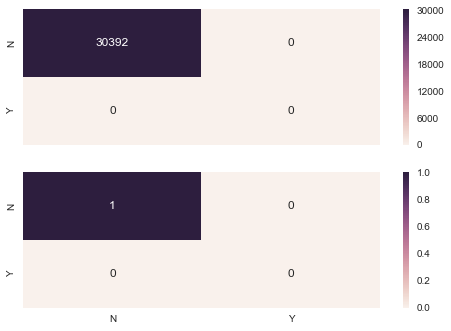

In [44]:
measure(bnb_predictions, prediction_outputs)

#### Gaussian Naive Bayes

{'accuracy': 0.955,
 'f1_measure': nan,
 'false_positive_rate': 0.045,
 'precision': 0.000,
 'recall': nan,
 'specificity': 0.955}

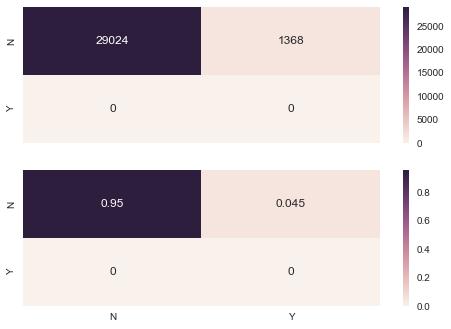

In [45]:
measure(gnb_predictions, prediction_outputs)

#### Multinomial Naive Bayes

{'accuracy': 0.957,
 'f1_measure': nan,
 'false_positive_rate': 0.043,
 'precision': 0.000,
 'recall': nan,
 'specificity': 0.957}

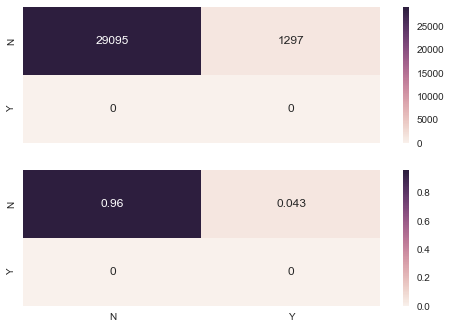

In [46]:
measure(mnb_predictions, prediction_outputs)

#### Custom Multinomial Naive Bayes

{'accuracy': 0.982,
 'f1_measure': nan,
 'false_positive_rate': 0.018,
 'precision': 0.000,
 'recall': nan,
 'specificity': 0.982}

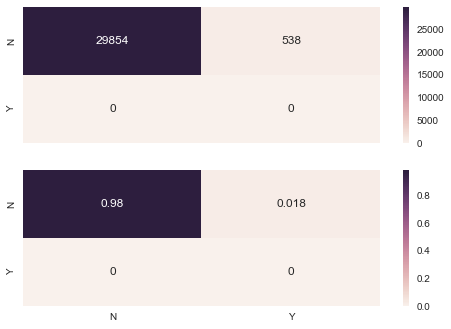

In [47]:
measure(custom_mnb_predictions, prediction_outputs)

#### Logistic Regression

{'accuracy': 1.000,
 'f1_measure': nan,
 'false_positive_rate': 0.000,
 'precision': nan,
 'recall': nan,
 'specificity': 1.000}

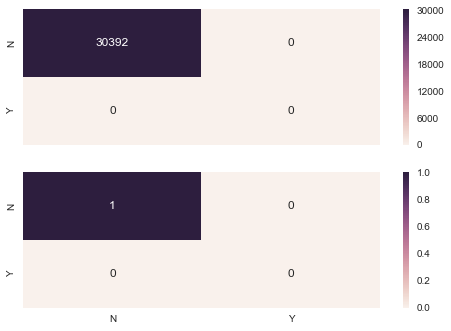

In [48]:
measure(reg_predictions, prediction_outputs)

## Output

In [49]:
def to_dataframe(pred):
    data = np.vstack([prediction_df.id.as_matrix(), pred]).T
    return pd.DataFrame(data, columns=["id", "y"])

prediction_only = to_dataframe(custom_mnb_predictions)
prediction_df["y"] = prediction_only["y"].as_matrix()

In [50]:
if PREDICTION_YEAR > MAX_YEAR:
    prediction_only.to_csv("naive_bayes_prediction.csv", index=False, header=False)

# Previous years comparison

In [51]:
year_on_year = []
for year in range(MIN_YEAR + 1, PREDICTION_YEAR):
    total = count(df[df.year == year])
    newbies = count(df[(df.year == year) & (df.run_count == 0)])
    oldies = total - newbies
    year_on_year.append([year, newbies, oldies, total, oldies / total])

year_on_year_df = pd.DataFrame(year_on_year,
                               columns=["year", "new", "returning", "total", "returning rate"])

In [52]:
year_on_year_df

,year,new,returning,total,returning rate
0,2004,1453,295,1748,0.168764
1,2005,1353,393,1746,0.225086
2,2006,2003,429,2432,0.176398
3,2007,1983,528,2511,0.210275
4,2008,2106,511,2617,0.195262
5,2009,2150,590,2740,0.215328
6,2010,2146,692,2838,0.243834
7,2011,2730,767,3497,0.219331
8,2012,2887,968,3855,0.251102
9,2013,3167,561,3728,0.150483
